### 安裝 facebook prophet

In [ ]:
!pip install pystan==2.19.1.1
!pip install prophet

### 讀取資料

In [26]:
# read close
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
close = pd.read_csv('/content/drive/MyDrive/colabData/close.csv')
print(close.head(5))
print(close.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
         date  0015   0050   0051   0052  ...  9951  9955  9958  9960  9962
0  2007-04-23  9.54  57.85  32.83  38.40  ...  51.3  72.4   NaN  46.0  49.6
1  2007-04-24  9.54  58.10  32.99  38.65  ...  50.5  71.6   NaN  45.9  50.4
2  2007-04-25  9.52  57.60  32.80  38.59  ...  49.9  71.6   NaN  49.1  49.1
3  2007-04-26  9.59  57.70  32.80  38.60  ...  49.5  71.0   NaN  48.9  48.0
4  2007-04-27  9.55  57.50  32.72  38.40  ...  48.8  69.5   NaN  48.6  46.5

[5 rows x 2308 columns]
(3652, 2308)


### 提取並處理所需的股票資料

In [27]:
# filter the date
data = close[(close['date'] > "2017-12-28")]

In [28]:
# get 0050
data_close = data[['date', '0050']]

In [29]:
# process data
train = data_close.rename(columns={'0050': 'y', 'date': 'ds'}, inplace=False)
train = train.interpolate(method='linear', limit_direction='forward', axis=0)

train.reset_index(inplace=True, drop=True)

train.tail()

,ds,y
996,2022-01-26,141.55
997,2022-02-07,142.30
998,2022-02-08,142.90
999,2022-02-09,143.40
1000,2022-02-10,145.05


### ProPhet 使用

In [36]:
from prophet import Prophet

m = Prophet()
m.fit(train)

future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)

pred_close = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

pred_close.tail(10)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
1021,2022-03-03,145.072303,142.491489,147.621937
1022,2022-03-04,144.824487,141.948667,147.537506
1023,2022-03-05,145.997639,143.065811,148.976251
1024,2022-03-06,146.478111,143.726285,149.350607
1025,2022-03-07,144.022058,141.059785,146.839381
1026,2022-03-08,143.836291,140.945431,146.817429
1027,2022-03-09,143.571138,140.746449,146.543533
1028,2022-03-10,143.320345,140.464966,146.046355
1029,2022-03-11,143.023705,140.167605,146.113758
1030,2022-03-12,144.172125,141.049629,147.116506


### 誤差統計

In [37]:
# filter the date
filter = pred_close[(pred_close['ds'] < "2022-02-11")]
yhat = filter['yhat'].values
print(len(yhat))

y = train['y'].values
print(len(y))

1001
1001


In [38]:
import numpy as np
mse = 0
for i in range(len(y)):
  mse = mse + (y[i] - yhat[i])**2.0
mse = mse / len(y)
print("mse:", mse)

rmse = np.sqrt(mse)
print("rmse: ", rmse)

mse: 4.361460909576461
rmse:  2.088411096881182


### 繪圖

In [39]:
# filter the date
pred_plot_data = pred_close[(pred_close['ds'] >= "2021-01-03")]
pred_plot_data.reset_index(inplace=True, drop=True)
pred_plot_data.tail()

,ds,yhat,yhat_lower,yhat_upper
291,2022-03-08,143.836291,140.945431,146.817429
292,2022-03-09,143.571138,140.746449,146.543533
293,2022-03-10,143.320345,140.464966,146.046355
294,2022-03-11,143.023705,140.167605,146.113758
295,2022-03-12,144.172125,141.049629,147.116506


In [40]:
filter = future
filter['y'] = np.nan
filter['y'] = train['y']

raw_plot_data = filter[(filter['ds'] >= "2021-01-03")]
raw_plot_data.reset_index(inplace=True, drop=True)
raw_plot_data.tail()

,ds,y
291,2022-03-08,NaN
292,2022-03-09,NaN
293,2022-03-10,NaN
294,2022-03-11,NaN
295,2022-03-12,NaN


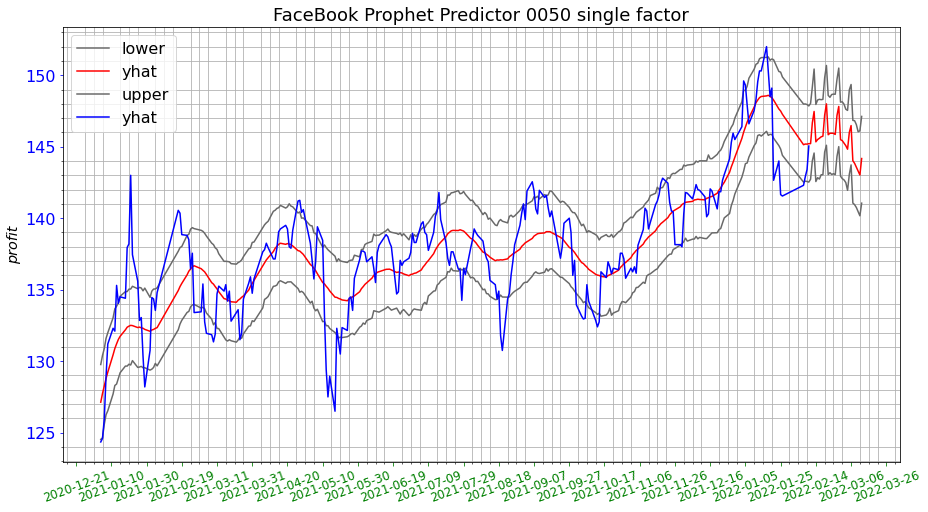

In [41]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(15,8)) #create figure
ax = fig.add_subplot(1, 1, 1) #create ax within figure

ax.plot(pred_plot_data['ds'], pred_plot_data['yhat_lower'], color='dimgray', label='lower')
ax.plot(pred_plot_data['ds'], pred_plot_data['yhat'], color='red', label='yhat')
ax.plot(pred_plot_data['ds'], pred_plot_data['yhat_upper'], color='dimgray', label='upper')
ax.plot(pred_plot_data['ds'], raw_plot_data['y'], color='blue', label='yhat')

ax.xaxis.set_major_locator(ticker.MultipleLocator(20)) #set xTicks interval
ax.xaxis.set_tick_params(rotation=20,labelsize=12,colors='g') #setting xticks
ax.yaxis.set_tick_params(labelsize=16,colors='b') #setting xticks
ax.minorticks_on()

ax.grid(which='minor', axis='both')
ax.set_title('FaceBook Prophet Predictor 0050 single factor',fontsize=18)
ax.set_ylabel('profit', fontsize='x-large',fontstyle='oblique')
ax.legend(fontsize=16)